# Experiments with natural gradient, constrained optimisation, and MCE IRL

This notebook contains the source for Sam's EE227C project. The aim is to apply (efficiently, somehow) natural gradient learning to maximum causal entropy IRL.

In [38]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import copy

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy

import imitation.tabular_irl as tirl
import imitation.model_env as menv

sns.set(context='notebook')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
mdp = menv.RandomMDP(
    n_states=16,
    n_actions=3,
    branch_factor=2,
    horizon=20,
    random_obs=True,
    obs_dim=5,
    generator_seed=42)
V, Q, pi = tirl.mce_partition_fh(mdp)
Dt, D = tirl.mce_occupancy_measures(mdp, pi=pi)
demo_counts = D @ mdp.observation_matrix
obs_dim, = demo_counts.shape
# opt = tirl.AMSGrad(init_weights, alpha=0.1)
# final_weights, final_counts = tirl.maxent_irl(
#     mdp, opt, demo_counts, linf_eps=1e-4)
# print('Final 2-norm of feature count differences:', np.linalg.norm(final_counts - demo_counts))
# print('Final 2-dist in recovered weights & real ones:', np.linalg.norm(final_weights - mdp._reward_weights))

In [3]:
rmodel = tirl.LinearRewardModel(obs_dim)
opt = tirl.SGD(rmodel, alpha=0.1)
final_weights, D_fake = tirl.maxent_irl(
    mdp, opt, rmodel, D, linf_eps=1e-2)

Occupancy measure error@iter   0: 5.927971 (||params||=3.245443, ||grad||=1.068068, ||E[dr/dw]||=1.692720)
Occupancy measure error@iter  100: 1.036213 (||params||=1.133271, ||grad||=0.138480, ||E[dr/dw]||=1.067898)
Occupancy measure error@iter  200: 0.430575 (||params||=1.338888, ||grad||=0.061337, ||E[dr/dw]||=1.105220)
Occupancy measure error@iter  300: 0.221955 (||params||=1.568149, ||grad||=0.035300, ||E[dr/dw]||=1.114983)
Occupancy measure error@iter  400: 0.137101 (||params||=1.740744, ||grad||=0.022459, ||E[dr/dw]||=1.118025)
Occupancy measure error@iter  500: 0.090622 (||params||=1.869396, ||grad||=0.015029, ||E[dr/dw]||=1.119600)
Occupancy measure error@iter  600: 0.063597 (||params||=1.964056, ||grad||=0.010426, ||E[dr/dw]||=1.120747)
Occupancy measure error@iter  700: 0.045753 (||params||=2.033431, ||grad||=0.007420, ||E[dr/dw]||=1.121624)
Occupancy measure error@iter  800: 0.033333 (||params||=2.084417, ||grad||=0.005374, ||E[dr/dw]||=1.122287)
Occupancy measure error@iter 

In [139]:
rmodel = tirl.LinearRewardModel(obs_dim)
opt = tirl.SGD(rmodel, alpha=1)
final_weights, D_fake = tirl.maxent_irl_ng(
    mdp, opt, rmodel, D, linf_eps=1e-2) 

Feature count error@iter   0: 2.228933 (||params||=1.939901, ||grad||=3.553647, ||step||=2.865981)
Feature count error@iter  10: 1.138104 (||params||=3.795299, ||grad||=1.799335, ||step||=0.062317)
Feature count error@iter  20: 0.811623 (||params||=4.117627, ||grad||=1.314698, ||step||=0.061041)
Feature count error@iter  30: 0.625062 (||params||=4.519341, ||grad||=1.040514, ||step||=0.094085)
Feature count error@iter  40: 0.430706 (||params||=4.844630, ||grad||=0.746604, ||step||=0.044497)
Feature count error@iter  50: 0.318159 (||params||=4.929907, ||grad||=0.557335, ||step||=0.020286)
Feature count error@iter  60: 0.251245 (||params||=4.966563, ||grad||=0.410331, ||step||=0.015519)
Feature count error@iter  70: 0.209192 (||params||=4.974050, ||grad||=0.328913, ||step||=0.013348)
Feature count error@iter  80: 0.178217 (||params||=4.973206, ||grad||=0.275464, ||step||=0.009416)


KeyboardInterrupt: 

In [66]:
rmodel = tirl.MLPRewardModel(obs_dim, [32, 32])
opt = tirl.SGD(rmodel, alpha=0.1)
final_weights, D_fake = tirl.maxent_irl(
    mdp, opt, rmodel, D, linf_eps=1e-2)

Feature count error@iter   0: 0.688725 (||params||=11.321621, ||grad||=4.420717, ||E[dr/dw]||=4.926618)
Feature count error@iter  10: 0.009899 (||params||=11.331171, ||grad||=0.060489, ||E[dr/dw]||=7.644481)


# Same shit, but on grid world

The true reward here is not linear in the reduced feature space (i.e $(x,y)$ coordinates). Hopefully MLP Just Works(tm) :)

Occupancy measure error@iter   0: 1.890754 (||params||=0.567095, ||grad||=0.100597, ||E[dr/dw]||=0.055576)


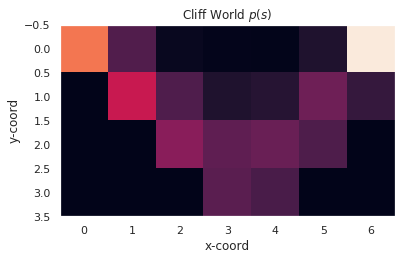

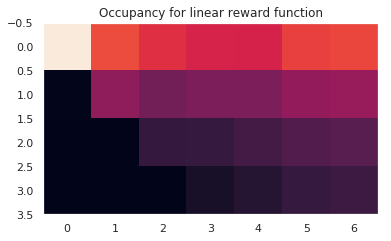

Text(0.5, 1.0, 'True reward')

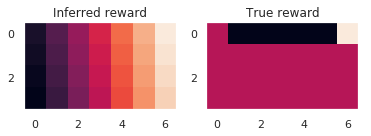

In [33]:
# Same experiments, but on grid world
mdp = menv.CliffWorld(
    width=7,
    height=4,
    horizon=8,
    use_xy_obs=True)
V, Q, pi = tirl.mce_partition_fh(mdp)
Dt, D = tirl.mce_occupancy_measures(mdp, pi=pi)
demo_counts = D @ mdp.observation_matrix
obs_dim, = demo_counts.shape
rmodel = tirl.LinearRewardModel(obs_dim)
opt = tirl.AMSGrad(rmodel, alpha=1)
final_weights, D_fake = tirl.maxent_irl(
    mdp, opt, rmodel, D, linf_eps=0.9)

mdp.draw_value_vec(D)
plt.title("Cliff World $p(s)$")
plt.xlabel('x-coord')
plt.ylabel('y-coord')
plt.show()

mdp.draw_value_vec(D_fake)
plt.title("Occupancy for linear reward function")
plt.show()
plt.subplot(1, 2, 1)
mdp.draw_value_vec(rmodel.out(mdp.observation_matrix))
plt.title("Inferred reward")
plt.subplot(1, 2, 2)
mdp.draw_value_vec(mdp.reward_matrix)
plt.title("True reward")

Occupancy measure error@iter   0: 1.688150 (||params||=3.538797, ||grad||=0.139814, ||E[dr/dw]||=0.305907)
Occupancy measure error@iter  250: 0.442002 (||params||=8.167179, ||grad||=0.009020, ||E[dr/dw]||=0.576279)
Occupancy measure error@iter  500: 0.257725 (||params||=10.404285, ||grad||=0.006482, ||E[dr/dw]||=0.642645)
Occupancy measure error@iter  750: 0.172945 (||params||=12.092210, ||grad||=0.007681, ||E[dr/dw]||=0.692340)
Occupancy measure error@iter  1000: 0.121372 (||params||=13.460113, ||grad||=0.006855, ||E[dr/dw]||=0.749596)
Occupancy measure error@iter  1250: 0.094740 (||params||=14.488353, ||grad||=0.006412, ||E[dr/dw]||=0.798246)
Occupancy measure error@iter  1500: 0.082594 (||params||=15.319768, ||grad||=0.005550, ||E[dr/dw]||=0.833132)
Occupancy measure error@iter  1750: 0.069187 (||params||=16.065908, ||grad||=0.006293, ||E[dr/dw]||=0.875014)
Occupancy measure error@iter  2000: 0.057221 (||params||=16.753403, ||grad||=0.005483, ||E[dr/dw]||=0.913818)
Occupancy measure

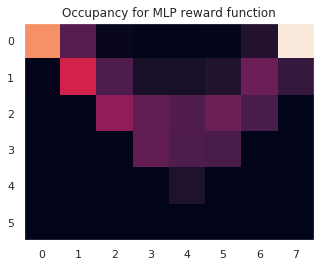

In [114]:
rmodel = tirl.MLPRewardModel(obs_dim, [1024,], activation='Relu')
opt = tirl.AMSGrad(rmodel, alpha=1e-3)
final_weights, D_fake_mlp = tirl.maxent_irl(
    mdp, opt, rmodel, D, linf_eps=1e-2, print_interval=250)
mdp.draw_value_vec(D_fake_mlp)
plt.title("Occupancy for MLP reward function")
plt.show()

Text(0.5, 1.0, 'True reward')

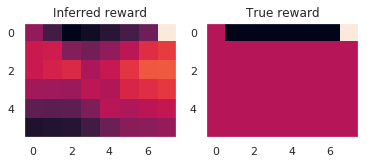

In [119]:
plt.subplot(1, 2, 1)
mdp.draw_value_vec(rmodel.out(mdp.observation_matrix))
plt.title("Inferred reward")
plt.subplot(1, 2, 2)
mdp.draw_value_vec(mdp.reward_matrix)
plt.title("True reward")

In [20]:
rmodel = tirl.MLPRewardModel(obs_dim, [16,16], activation='Tanh')
opt = tirl.SGD(rmodel, alpha=0.05)
final_weights, D_fake_mlp = tirl.maxent_irl_ng(
    mdp, opt, rmodel, D, linf_eps=5e-2, fim_ident_eps=1e-5, print_interval=10, fim_ntraj=50)
mdp.draw_value_vec(D_fake_mlp)
plt.title("Occupancy for MLP reward function")
plt.show()

Occupancy measure error@iter   0: 1.563550 (||params||=6.244777, ||grad||=0.213453, ||step||=159.607921)


AssertionError: [nan nan nan nan]

In [ ]:
plt.subplot(1, 2, 1)
mdp.draw_value_vec(rmodel.out(mdp.observation_matrix))
plt.title("Inferred reward")
plt.subplot(1, 2, 2)
mdp.draw_value_vec(mdp.reward_matrix)
plt.title("True reward")

# Experiments & plots for poster & report

List of things I want: basically all combinations of the attributes below.

- **Environment:** grid (impoverished), random ($s=16$, $o=32$), random ($s=16$, $o=256$), random ($s=128$, $o=128$).
- **Optimizer:** GD, natural GD, mirror descent, multiplicative weights.
- **Model:** linear, neural network (with $16,16$ hidden layers)

In all cases you should tune for best performance of the method. Probably run each experiment ~10 times over different initialisations. That's going to be a lot of experiments: something like $4 \times 4 \times 2 \times 10 = 320$ Running on svm, perceptron, or astar and using multiprocessing will probably be necessary. After training, I want to plot the following:

- Actual loss, measured as $E_{\tau \sim \mathcal D}[\log p_\theta(\tau)]$
- Amount by which the policy's visitations change at each iteration, as measured by either $\ell_1$ or $\ell_\infty$ norm, or maybe by KL

In [69]:
sns.set(context='notebook', style='darkgrid', font_scale=2.0)

Occupancy measure error@iter   0: 9.737521 (||params||=15.221732, ||grad||=13.078601, ||E[dr/dw]||=11.329839)


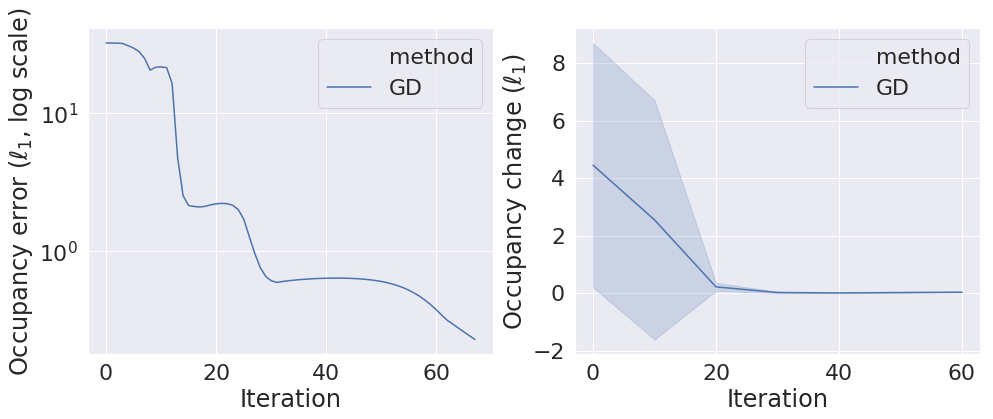

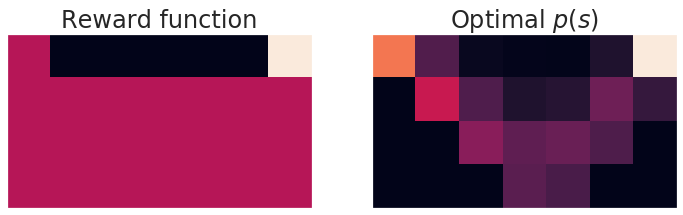

Occupancy measure error@iter   0: 1.348356 (||params||=4.761093, ||grad||=0.178548, ||E[dr/dw]||=0.698374)
Occupancy measure error@iter  1000: 0.051234 (||params||=16.397951, ||grad||=0.001883, ||E[dr/dw]||=2.293918)


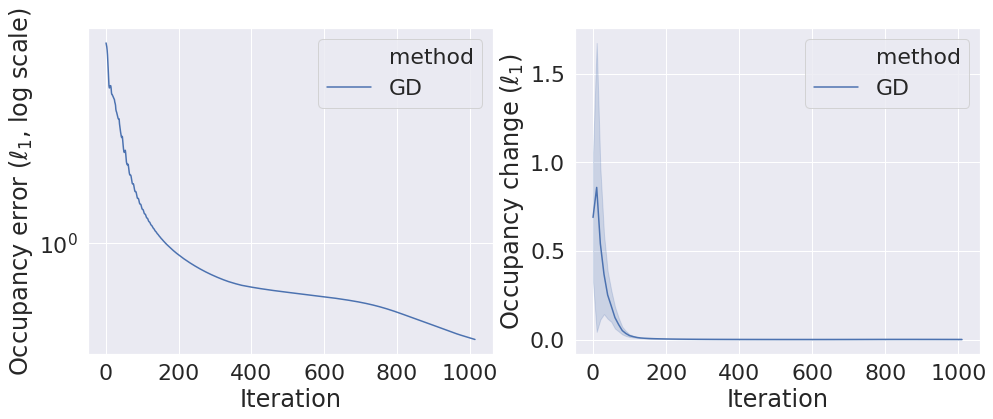

In [72]:
!mkdir -p figures

def execute_experiment(mdp, rmodel, demo_counts, linf_eps=1e-2):
    """Execute GD/NG/MD on given MDP using given rmodel as the initial model.
    Plot the results as appropriate."""
    def _make_results(method_name, occupancy_error, occupancy_change):
        T = len(occupancy_error)
        assert len(occupancy_change) == T
        iter_nums = np.arange(T)
        iter_windowed = []
        occupancy_change_windowed = []
        W = 10
        # version of iter_nums that's clamped to lower part
        # of each window; useful for getting Seaborn to
        # do a standard deviation estimate across each window
        iter_windowed = W * np.floor(iter_nums / W)
        return pd.DataFrame.from_dict({
            "iter": iter_nums,
            "method": [method_name] * T,
            "error": occupancy_error,
            "policy_change": occupancy_change,
            "iter_windowed": iter_windowed,
        })

    # First method: gradient descent
    rmodel_gd = copy.deepcopy(rmodel)
    opt_gd = tirl.AMSGrad(rmodel, alpha=1e-2)
    occ_err_gd = []
    occ_change_gd = []
    final_weights, D_fake_mlp = tirl.maxent_irl(
        mdp, opt_gd, rmodel_gd, demo_counts,
        linf_eps=linf_eps, print_interval=1000,
        occupancy_change_dest=occ_change_gd,
        occupancy_error_dest=occ_err_gd)
    gd_result = _make_results("GD", occ_err_gd, occ_change_gd)

    # Second method: natural gradient
    rmodel_ng = copy.deepcopy(rmodel)
    opt_ng = tirl.SGD(rmodel_ng, alpha=1e-2)

    # Third method: mirror descent
    rmodel_md = copy.deepcopy(rmodel)
    # we use step size of 1; otherwise things screw up
    opt_md = tirl.SGD(rmodel_md, alpha=1)

    # FIXME: use all methods
    # data = pd.concatenate((gd_result, ng_result, md_result))
    data = gd_result
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.lineplot(data=data, x='iter', y='error', hue='method')
    plt.xlabel("Iteration")
    plt.ylabel(r"Occupancy error ($\ell_1$, log scale)")
    plt.yscale('log')
    plt.subplot(1, 2, 2)
    sns.lineplot(data=data, x='iter_windowed', y='policy_change', hue='method', ci='sd')
    plt.xlabel("Iteration")
    plt.ylabel(r"Occupancy change ($\ell_1$)")

mdp_big = menv.RandomMDP(
    n_states=16,
    n_actions=4,
    branch_factor=2,
    horizon=20,
    random_obs=True,
    obs_dim=256,
    generator_seed=42)
mdp_big_Dt, mdp_big_D = tirl.mce_occupancy_measures(mdp_big)
mdp_big_linear_model = tirl.LinearRewardModel(mdp_big.observation_matrix.shape[1], seed=7)
mdp_big_result = execute_experiment(mdp_big, mdp_big_linear_model, mdp_big_D, linf_eps=0.05)  # XXX bad linf_eps
plt.show()

# Same experiments, but on grid world
grid_cliff = menv.CliffWorld(
    width=7,
    height=4,
    horizon=8,
    use_xy_obs=True)
grid_cliff_Dt, grid_cliff_D = tirl.mce_occupancy_measures(grid_cliff)

# plot our nice environment
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
grid_cliff.draw_value_vec(mdp.reward_matrix)
plt.title("Reward function")
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.subplot(1, 2, 2)
grid_cliff.draw_value_vec(grid_cliff_D)
plt.title("Optimal $p(s)$")
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.savefig("figures/gw_illustration.png")
plt.show()

grid_cliff_neural_net = tirl.MLPRewardModel(grid_cliff.observation_matrix.shape[1], [8, 8], activation='Tanh', seed=7)
cliff_result = execute_experiment(grid_cliff, grid_cliff_neural_net, grid_cliff_D, linf_eps=0.05)  # XXX bad linf_eps
plt.show()